In [32]:
import pandas as pd
import csv
import os
import numpy as np
import nltk
import re

In [33]:
# Specify file paths
train_file = 'train.csv'
test_file = 'test.csv'

# Download Train and Test Files
!wget -O {train_file} https://raw.githubusercontent.com/piru72/a-study-on-application-of-knowledge-graph/main/dataset/AISecKG/train.csv
!wget -O {test_file} https://raw.githubusercontent.com/piru72/a-study-on-application-of-knowledge-graph/main/dataset/AISecKG/test.csv

# Load the datasets into pandas
import pandas as pd
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Display a summary of the data (optional)
print(train_data.head())
print(test_data.head())


--2024-12-16 12:53:03--  https://raw.githubusercontent.com/piru72/a-study-on-application-of-knowledge-graph/main/dataset/AISecKG/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97937 (96K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  95.64K  --.-KB/s    in 0.02s   

2024-12-16 12:53:03 (3.99 MB/s) - ‘train.csv’ saved [97937/97937]

--2024-12-16 12:53:03--  https://raw.githubusercontent.com/piru72/a-study-on-application-of-knowledge-graph/main/dataset/AISecKG/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, aw

In [34]:
train_data.head(100)

,DocNo,sentence,tag
0,D3,of,O
1,D2,immediately,O
2,D3,based,O
3,D3,and,O
4,NaN,NaN,NaN
...,...,...,...
95,D1,a,O
96,D2,scanned,B-FUNCTION
97,D2,often,O
98,D3,Metasploit,I-TOOL


In [36]:
test_data.head(100)

,DocNo,sentence,tag
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,D5,and,O
3,D5,incoming,O
4,D4,exploits,B-FUNCTION
...,...,...,...
95,D4,followed,O
96,D4,is,O
97,D4,With,O
98,D3,of,O


# TransE

In [5]:
import random
random.seed(42)

In [8]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim

# Load dataset
train_data=pd.read_csv('train.csv')
train_data = train_data.dropna()

# Step 1: Create mappings for entities and relations
entities = list(set(train_data['DocNo'].unique()).union(set(train_data['tag'].unique())))
relations = list(train_data['sentence'].unique())
entity2id = {entity: idx for idx, entity in enumerate(entities)}
relation2id = {relation: idx for idx, relation in enumerate(relations)}

# Step 2: Convert dataset to triples
triples = train_data.apply(lambda row: (entity2id[row['DocNo']],
                                        relation2id[row['sentence']],
                                        entity2id[row['tag']]), axis=1).tolist()

# TransE Model
class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(TransE, self).__init__()
        self.entity_embedding = nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding = nn.Embedding(num_relations, embedding_dim)
        nn.init.xavier_uniform_(self.entity_embedding.weight)
        nn.init.xavier_uniform_(self.relation_embedding.weight)

    def forward(self, heads, relations, tails):
        h = self.entity_embedding(heads)
        r = self.relation_embedding(relations)
        t = self.entity_embedding(tails)
        return h + r - t

# Custom Dataset
class TripleDataset(Dataset):
    def __init__(self, triples):
        self.triples = triples

    def __len__(self):
        return len(self.triples)

    def __getitem__(self, idx):
        return torch.tensor(self.triples[idx])

# Negative Sampling Function
def generate_negative_samples(batch_size, num_entities):
    """
    Generates negative samples for a batch of size `batch_size`.
    Returns negative tails sampled randomly.
    """
    neg_tails = torch.randint(0, num_entities, (batch_size,))
    return neg_tails

# Updated Loss Function
class MarginRankingLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, pos_scores, neg_scores):
        # Create a label tensor for margin ranking loss (+1 for positive scores)
        target = torch.ones_like(pos_scores)
        return torch.mean(torch.relu(self.margin + pos_scores - neg_scores))

# Training Setup
embedding_dim = 100  # Updated embedding dimension
num_epochs = 100    # Increase epochs
learning_rate = 0.001
batch_size = 64    # Updated batch size
margin = 1.0         # Margin for ranking loss

model = TransE(len(entities), len(relations), embedding_dim)
dataset = TripleDataset(triples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_fn = MarginRankingLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop with Negative Sampling and Accuracy
for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    model.train()

    for batch in dataloader:
        # Positive Samples
        heads, relations, tails = batch[:, 0], batch[:, 1], batch[:, 2]
        pos_scores = torch.norm(model(heads, relations, tails), dim=1)

        # Generate Negative Samples
        neg_tails = generate_negative_samples(len(tails), len(entities))
        neg_scores = torch.norm(model(heads, relations, neg_tails), dim=1)

        # Loss and Optimization
        loss = loss_fn(pos_scores, neg_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate Accuracy
        with torch.no_grad():
            # Combine positive and negative scores for ranking
            all_scores = torch.cat([pos_scores, neg_scores])
            all_labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)])

            # Accuracy as the fraction of correctly ranked positive samples
            predicted_labels = (all_scores[:len(tails)] < all_scores[len(tails):]).float()
            batch_correct = (predicted_labels == all_labels[:len(tails)]).sum().item()
            total_correct += batch_correct
            total_samples += len(tails)

    accuracy = total_correct / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.2f}, Accuracy: {accuracy:.2f}")




Epoch 1/100, Loss: 70.12, Accuracy: 0.80
Epoch 2/100, Loss: 41.36, Accuracy: 0.85
Epoch 3/100, Loss: 36.42, Accuracy: 0.86
Epoch 4/100, Loss: 32.06, Accuracy: 0.88
Epoch 5/100, Loss: 28.65, Accuracy: 0.89
Epoch 6/100, Loss: 25.94, Accuracy: 0.90
Epoch 7/100, Loss: 22.34, Accuracy: 0.91
Epoch 8/100, Loss: 22.29, Accuracy: 0.91
Epoch 9/100, Loss: 20.72, Accuracy: 0.92
Epoch 10/100, Loss: 18.86, Accuracy: 0.93
Epoch 11/100, Loss: 17.51, Accuracy: 0.93
Epoch 12/100, Loss: 16.23, Accuracy: 0.93
Epoch 13/100, Loss: 16.29, Accuracy: 0.93
Epoch 14/100, Loss: 14.80, Accuracy: 0.94
Epoch 15/100, Loss: 14.86, Accuracy: 0.93
Epoch 16/100, Loss: 13.74, Accuracy: 0.93
Epoch 17/100, Loss: 12.48, Accuracy: 0.94
Epoch 18/100, Loss: 13.26, Accuracy: 0.94
Epoch 19/100, Loss: 12.37, Accuracy: 0.95
Epoch 20/100, Loss: 11.25, Accuracy: 0.95
Epoch 21/100, Loss: 11.63, Accuracy: 0.94
Epoch 22/100, Loss: 10.95, Accuracy: 0.95
Epoch 23/100, Loss: 10.43, Accuracy: 0.95
Epoch 24/100, Loss: 10.03, Accuracy: 0.96
E

In [9]:
# Save the trained model
torch.save(model.state_dict(), 'transe_model.pth')

<ipython-input-10-9859e1b54a54>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(checkpoint_path)


Mean Rank: 9.64
Precision: 0.48
Recall: 0.50
F1 Score: 0.49
AUC: 0.64
Accuracy: 0.96


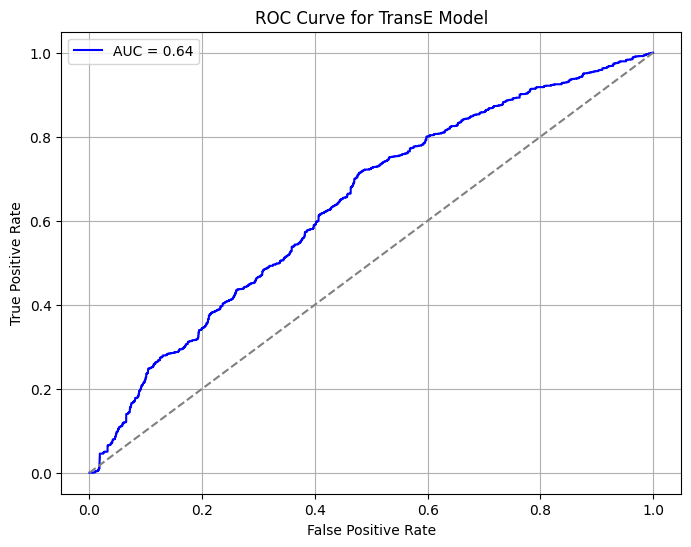

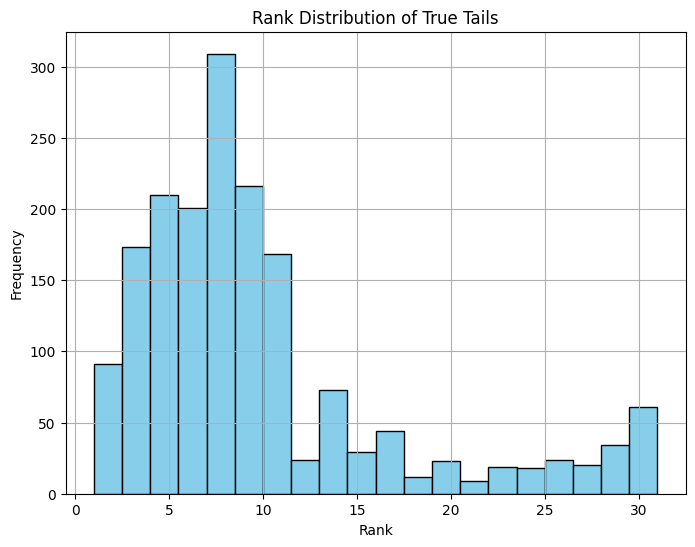

In [10]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Load test data

test_data=pd.read_csv('test.csv')

# Drop rows with missing values
test_data = test_data.dropna()

# Load train data to create mappings
train_data=pd.read_csv('train.csv')

# Step 1: Create mappings for entities and relations based on training data
def create_mappings(train_data):
    entities = list(set(train_data['DocNo'].unique()).union(set(train_data['tag'].unique())))
    relations = list(train_data['sentence'].unique())
    entity2id = {entity: idx for idx, entity in enumerate(entities)}
    relation2id = {relation: idx for idx, relation in enumerate(relations)}
    return entity2id, relation2id

def convert_to_triples(data, entity2id, relation2id):
    triples = []
    for _, row in data.iterrows():
        head = entity2id.get(row['DocNo'], None)
        relation = relation2id.get(row['sentence'], None)
        tail = entity2id.get(row['tag'], None)

        # Dynamically add missing entities/relations to the mappings
        if head is None:
            head = len(entity2id)
            entity2id[row['DocNo']] = head
        if relation is None:
            relation = len(relation2id)
            relation2id[row['sentence']] = relation
        if tail is None:
            tail = len(entity2id)
            entity2id[row['tag']] = tail

        triples.append((head, relation, tail))
    return triples

entity2id, relation2id = create_mappings(train_data)
test_triples = convert_to_triples(test_data, entity2id, relation2id)

# TransE Model
class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(TransE, self).__init__()
        self.entity_embedding = nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding = nn.Embedding(num_relations, embedding_dim)

    def forward(self, heads, relations, tails):
        h = self.entity_embedding(heads)
        r = self.relation_embedding(relations)
        t = self.entity_embedding(tails)
        return h + r - t

# Load the trained model with dynamic resizing
def load_trained_model(checkpoint_path, entity2id, relation2id, embedding_dim):
    saved_state = torch.load(checkpoint_path)

    num_entities_pretrained = saved_state['entity_embedding.weight'].size(0)
    num_relations_pretrained = saved_state['relation_embedding.weight'].size(0)

    num_entities_current = len(entity2id)
    num_relations_current = len(relation2id)
    model = TransE(num_entities_current, num_relations_current, embedding_dim)

    if num_entities_current > num_entities_pretrained:
        new_entity_weights = torch.cat([
            saved_state['entity_embedding.weight'],
            torch.empty(num_entities_current - num_entities_pretrained, embedding_dim).uniform_(-0.01, 0.01)
        ], dim=0)
        saved_state['entity_embedding.weight'] = new_entity_weights
    elif num_entities_current < num_entities_pretrained:
        saved_state['entity_embedding.weight'] = saved_state['entity_embedding.weight'][:num_entities_current]

    if num_relations_current > num_relations_pretrained:
        new_relation_weights = torch.cat([
            saved_state['relation_embedding.weight'],
            torch.empty(num_relations_current - num_relations_pretrained, embedding_dim).uniform_(-0.01, 0.01)
        ], dim=0)
        saved_state['relation_embedding.weight'] = new_relation_weights
    elif num_relations_current < num_relations_pretrained:
        saved_state['relation_embedding.weight'] = saved_state['relation_embedding.weight'][:num_relations_current]

    model.load_state_dict(saved_state)
    return model

embedding_dim =100
model = load_trained_model('transe_model.pth', entity2id, relation2id, embedding_dim)
model.eval()

# Function to compute predictions
def predict_tail_ranks(model, triples, entity_count):
    ranks = []
    y_true = []
    y_scores = []

    with torch.no_grad():
        for head, relation, tail in triples:
            h = model.entity_embedding(torch.tensor(head))
            r = model.relation_embedding(torch.tensor(relation))
            true_tail_embedding = model.entity_embedding(torch.tensor(tail))

            scores = torch.norm(h + r - model.entity_embedding.weight, dim=1)
            rank = torch.argsort(scores).tolist().index(tail) + 1
            ranks.append(rank)

            y_true.append(1)
            y_scores.append(1 - scores[tail].item())

            for neg_tail in range(entity_count):
                if neg_tail != tail:
                    y_true.append(0)
                    y_scores.append(1 - scores[neg_tail].item())

    return ranks, y_true, y_scores

ranks, y_true, y_scores = predict_tail_ranks(model, test_triples, len(entity2id))

y_pred = [1 if score >= 0.5 else 0 for score in y_scores]

mean_rank = np.mean(ranks)
precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_scores)
accuracy = accuracy_score(y_true, y_pred)

print(f"Mean Rank: {mean_rank:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='b')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for TransE Model')
plt.legend()
plt.grid()
plt.show()

# Plot Rank Distribution
plt.figure(figsize=(8, 6))
plt.hist(ranks, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Rank Distribution of True Tails')
plt.grid()
plt.show()


# DistMult

In [11]:
import random
random.seed(42)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Load dataset
train_data=pd.read_csv('train.csv')
data1 = train_data.dropna()


# Step 1: Prepare the Dataset
# Assuming 'train' is a DataFrame with columns ['DocNo', 'sentence', 'tag']
# Create mappings for entities and relations
entities = list(set(data1['DocNo'].unique()).union(set(data1['tag'].unique())))
relations = list(data1['sentence'].unique())

entity2id = {entity: idx for idx, entity in enumerate(entities)}
relation2id = {relation: idx for idx, relation in enumerate(relations)}

# Convert train dataset to triples
triples = data1.apply(lambda row: (entity2id[row['DocNo']],
                                   relation2id[row['sentence']],
                                   entity2id[row['tag']]), axis=1).tolist()

# Step 2: Define DistMult Model
class DistMult(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(DistMult, self).__init__()
        self.entity_embedding = nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding = nn.Embedding(num_relations, embedding_dim)
        nn.init.xavier_uniform_(self.entity_embedding.weight)
        nn.init.xavier_uniform_(self.relation_embedding.weight)

    def forward(self, heads, relations, tails):
        h = self.entity_embedding(heads)
        r = self.relation_embedding(relations)
        t = self.entity_embedding(tails)
        scores = torch.sum(h * r * t, dim=1)  # Bilinear score computation
        return scores

# Step 3: Define Dataset and DataLoader
class TripleDataset(Dataset):
    def __init__(self, triples):
        self.triples = triples

    def __len__(self):
        return len(self.triples)

    def __getitem__(self, idx):
        return torch.tensor(self.triples[idx])

# Step 4: Negative Sampling Function
def generate_negative_samples(triples, num_entities, num_samples=1):
    negative_triples = []
    for head, relation, tail in triples:
        for _ in range(num_samples):
            if torch.rand(1).item() < 0.5:  # Corrupt head
                corrupt_head = torch.randint(0, num_entities, (1,)).item()
                while corrupt_head == head:  # Ensure it's different
                    corrupt_head = torch.randint(0, num_entities, (1,)).item()
                negative_triples.append((corrupt_head, relation, tail))
            else:  # Corrupt tail
                corrupt_tail = torch.randint(0, num_entities, (1,)).item()
                while corrupt_tail == tail:  # Ensure it's different
                    corrupt_tail = torch.randint(0, num_entities, (1,)).item()
                negative_triples.append((head, relation, corrupt_tail))
    return negative_triples

# Step 5: Training Setup
embedding_dim = 50
num_epochs = 100
learning_rate = 0.0001
batch_size = 32
negative_samples_per_positive = 5

model = DistMult(len(entities), len(relations), embedding_dim)
dataset = TripleDataset(triples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Step 6: Training Loop
for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    model.train()

    for batch in dataloader:
        positive_heads, positive_relations, positive_tails = batch[:, 0], batch[:, 1], batch[:, 2]

        # Generate negative samples
        negatives = generate_negative_samples(batch.tolist(), len(entities), negative_samples_per_positive)
        negative_heads = torch.tensor([neg[0] for neg in negatives])
        negative_relations = torch.tensor([neg[1] for neg in negatives])
        negative_tails = torch.tensor([neg[2] for neg in negatives])

        # Concatenate positive and negative samples
        all_heads = torch.cat([positive_heads, negative_heads])
        all_relations = torch.cat([positive_relations, negative_relations])
        all_tails = torch.cat([positive_tails, negative_tails])

        # Create labels: 1 for positive, 0 for negative
        labels = torch.cat([torch.ones(len(positive_heads)), torch.zeros(len(negative_heads))])

        # Compute scores
        scores = model(all_heads, all_relations, all_tails)

        # Compute loss
        loss = criterion(scores, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate predictions and accuracy
        predictions = (scores > 0).float()  # Convert logits to binary predictions
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.2f}, Accuracy: {accuracy:.2f}")

print("Training complete.")


Epoch 1/100, Loss: 152.48, Accuracy: 0.51
Epoch 2/100, Loss: 152.44, Accuracy: 0.53
Epoch 3/100, Loss: 152.38, Accuracy: 0.55
Epoch 4/100, Loss: 152.30, Accuracy: 0.58
Epoch 5/100, Loss: 152.17, Accuracy: 0.62
Epoch 6/100, Loss: 151.94, Accuracy: 0.66
Epoch 7/100, Loss: 151.59, Accuracy: 0.70
Epoch 8/100, Loss: 151.02, Accuracy: 0.74
Epoch 9/100, Loss: 150.20, Accuracy: 0.78
Epoch 10/100, Loss: 149.00, Accuracy: 0.81
Epoch 11/100, Loss: 147.30, Accuracy: 0.84
Epoch 12/100, Loss: 145.21, Accuracy: 0.86
Epoch 13/100, Loss: 142.53, Accuracy: 0.87
Epoch 14/100, Loss: 139.45, Accuracy: 0.89
Epoch 15/100, Loss: 135.98, Accuracy: 0.89
Epoch 16/100, Loss: 131.96, Accuracy: 0.90
Epoch 17/100, Loss: 127.90, Accuracy: 0.90
Epoch 18/100, Loss: 123.64, Accuracy: 0.90
Epoch 19/100, Loss: 119.35, Accuracy: 0.90
Epoch 20/100, Loss: 115.41, Accuracy: 0.90
Epoch 21/100, Loss: 110.86, Accuracy: 0.91
Epoch 22/100, Loss: 107.15, Accuracy: 0.91
Epoch 23/100, Loss: 103.54, Accuracy: 0.90
Epoch 24/100, Loss: 

In [13]:
# Save the trained model
torch.save(model.state_dict(), 'dismult_model.pth')

<ipython-input-15-80e359d5fa3f>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/dismult_model.pth'))  # Update path if necessary

Mean Rank: 1.60
Precision: 0.99
Recall: 0.86
F1 Score: 0.92
Accuracy: 0.92
AUC: 0.99


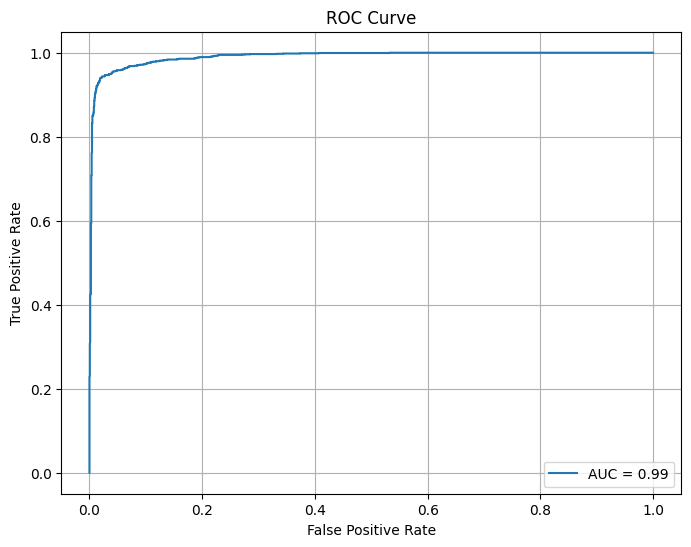

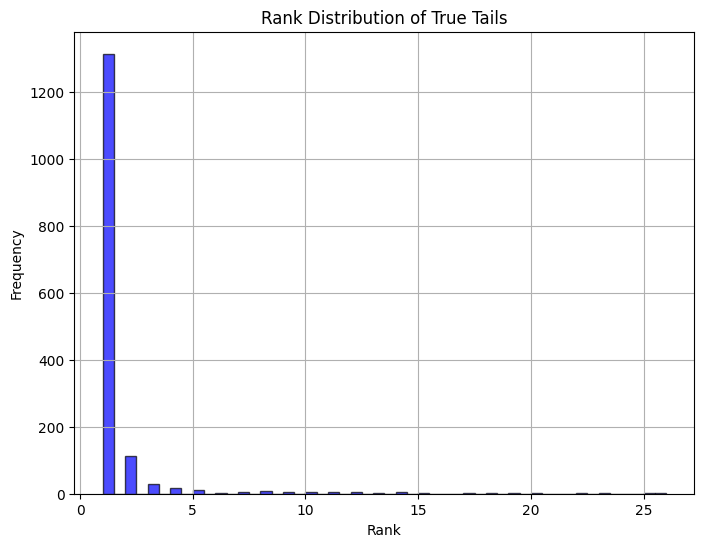

In [15]:
import torch
import pandas as pd
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt

# Define DistMult Model
class DistMult(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(DistMult, self).__init__()
        self.entity_embedding = nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding = nn.Embedding(num_relations, embedding_dim)
        nn.init.xavier_uniform_(self.entity_embedding.weight)
        nn.init.xavier_uniform_(self.relation_embedding.weight)

    def forward(self, heads, relations, tails):
        h = self.entity_embedding(heads)
        r = self.relation_embedding(relations)
        t = self.entity_embedding(tails)
        scores = torch.sum(h * r * t, dim=1)  # Bilinear score computation
        return scores

# Load test data
train_data=pd.read_csv('train.csv').dropna()
test_data=pd.read_csv('test.csv').dropna()

# Create mappings for entities and relations from the training data
entities = list(set(train_data['DocNo'].unique()).union(set(train_data['tag'].unique())))
relations = list(train_data['sentence'].unique())
entity2id = {entity: idx for idx, entity in enumerate(entities)}
relation2id = {relation: idx for idx, relation in enumerate(relations)}

# Map test dataset to triples
test_triples = test_data.apply(
    lambda row: (
        entity2id.get(row['DocNo'], -1),
        relation2id.get(row['sentence'], -1),
        entity2id.get(row['tag'], -1)
    ),
    axis=1
).tolist()

# Filter out triples with unknown entities/relations
test_triples = [triple for triple in test_triples if -1 not in triple]

# Define a function to compute ranks for test triples
def compute_ranks(model, triples, num_entities):
    ranks = []
    with torch.no_grad():
        for head, relation, tail in triples:
            head_tensor = torch.tensor([head] * num_entities)
            relation_tensor = torch.tensor([relation] * num_entities)
            tail_tensor = torch.arange(num_entities)
            scores = model(head_tensor, relation_tensor, tail_tensor)
            true_tail_score = scores[tail].item()
            rank = torch.sum(scores >= true_tail_score).item()
            ranks.append(rank)
    return ranks

# Load trained model
num_entities = len(entity2id)
num_relations = len(relation2id)
embedding_dim = 50  # Match training configuration

model = DistMult(num_entities, num_relations, embedding_dim)
model.load_state_dict(torch.load('/content/dismult_model.pth'))  # Update path if necessary
model.eval()

# Compute ranks for the test triples
ranks = compute_ranks(model, test_triples, num_entities)
mean_rank = sum(ranks) / len(ranks)

# Evaluate metrics
true_labels = []
predicted_scores = []
with torch.no_grad():
    for head, relation, tail in test_triples:
        score = model(torch.tensor([head]), torch.tensor([relation]), torch.tensor([tail]))
        true_labels.append(1)
        predicted_scores.append(score.item())

        corrupt_tail = torch.randint(0, num_entities, (1,)).item()
        while corrupt_tail == tail:
            corrupt_tail = torch.randint(0, num_entities, (1,)).item()

        score_corrupt = model(torch.tensor([head]), torch.tensor([relation]), torch.tensor([corrupt_tail]))
        true_labels.append(0)
        predicted_scores.append(score_corrupt.item())

predicted_labels = [1 if score > 0 else 0 for score in predicted_scores]
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average="binary")
accuracy = accuracy_score(true_labels, predicted_labels)
auc = roc_auc_score(true_labels, predicted_scores)

# Print Metrics
metrics = {
    "Mean Rank": mean_rank,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Accuracy": accuracy,
    "AUC": auc,
}

for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Generate ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Rank Distribution Plot
plt.figure(figsize=(8, 6))
plt.hist(ranks, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Rank Distribution of True Tails")
plt.grid()
plt.show()




# RotatE

In [39]:
import random
random.seed(42)

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import pickle

# Load training data
train_data = pd.read_csv('train.csv')
data2 = train_data.dropna()

# Step 1: Create mappings for entities and relations
entities = list(set(data2['DocNo'].unique()).union(set(data2['tag'].unique())))
relations = list(data2['sentence'].unique())

entity2id = {entity: idx for idx, entity in enumerate(entities)}
relation2id = {relation: idx for idx, relation in enumerate(relations)}

# Save mappings for testing
with open("entity2id.pkl", "wb") as f:
    pickle.dump(entity2id, f)
with open("relation2id.pkl", "wb") as f:
    pickle.dump(relation2id, f)

# Step 2: Convert dataset to IDs
triples = data2.apply(lambda row: (entity2id[row['DocNo']],
                                  relation2id[row['sentence']],
                                  entity2id[row['tag']]), axis=1).tolist()

# RotatE Model Definition
class RotatE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim, margin=1.0):
        super(RotatE, self).__init__()

        self.embedding_dim = embedding_dim
        self.margin = margin

        # Entity and relation embeddings
        self.entity_embedding_real = nn.Embedding(num_entities, embedding_dim)
        self.entity_embedding_imag = nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding_real = nn.Embedding(num_relations, embedding_dim)
        self.relation_embedding_imag = nn.Embedding(num_relations, embedding_dim)

        nn.init.xavier_uniform_(self.entity_embedding_real.weight)
        nn.init.xavier_uniform_(self.entity_embedding_imag.weight)
        nn.init.xavier_uniform_(self.relation_embedding_real.weight)
        nn.init.xavier_uniform_(self.relation_embedding_imag.weight)

    def forward(self, heads, relations, tails):
        h_real = self.entity_embedding_real(heads)
        h_imag = self.entity_embedding_imag(heads)
        t_real = self.entity_embedding_real(tails)
        t_imag = self.entity_embedding_imag(tails)
        r_real = self.relation_embedding_real(relations)
        r_imag = self.relation_embedding_imag(relations)

        rotated_real = h_real + r_real
        rotated_imag = h_imag + r_imag

        score = torch.norm((rotated_real - t_real) ** 2 + (rotated_imag - t_imag) ** 2, p=2, dim=1)
        return score

    def loss(self, positive_score, negative_score):
        return torch.sum(torch.clamp(positive_score - negative_score + self.margin, min=0))

# Training Setup
embedding_dim = 100
num_epochs = 100
learning_rate = 0.0001
batch_size = 32
margin = 1.0

model = RotatE(len(entities), len(relations), embedding_dim, margin)
dataset = torch.utils.data.TensorDataset(torch.tensor(triples))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for batch in dataloader:
        batch = batch[0]  # Extract tensor
        heads, relations, tails = batch[:, 0], batch[:, 1], batch[:, 2]

        # Positive scores
        positive_score = model(heads, relations, tails)

        # Negative sampling: replace tails with random entities for negative samples
        negative_tails = torch.randint(0, len(entities), (batch.size(0),))

        # Negative scores
        negative_score = model(heads, relations, negative_tails)

        # Compute loss
        loss = model.loss(positive_score, negative_score)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute accuracy: Positive scores should be lower than negative scores
        correct += (positive_score < negative_score).sum().item()
        total_samples += batch.size(0)

    accuracy = correct / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.2f}, Accuracy: {accuracy:.2f}")

print("Training Complete.")

Epoch 1/100, Loss: 6682.01, Accuracy: 0.69
Epoch 2/100, Loss: 5523.94, Accuracy: 0.84
Epoch 3/100, Loss: 4565.19, Accuracy: 0.85
Epoch 4/100, Loss: 3752.44, Accuracy: 0.85
Epoch 5/100, Loss: 3208.71, Accuracy: 0.86
Epoch 6/100, Loss: 2916.65, Accuracy: 0.86
Epoch 7/100, Loss: 2693.12, Accuracy: 0.86
Epoch 8/100, Loss: 2516.48, Accuracy: 0.87
Epoch 9/100, Loss: 2386.68, Accuracy: 0.87
Epoch 10/100, Loss: 2259.40, Accuracy: 0.87
Epoch 11/100, Loss: 2301.62, Accuracy: 0.86
Epoch 12/100, Loss: 2151.54, Accuracy: 0.87
Epoch 13/100, Loss: 2120.62, Accuracy: 0.87
Epoch 14/100, Loss: 1984.37, Accuracy: 0.88
Epoch 15/100, Loss: 2003.09, Accuracy: 0.88
Epoch 16/100, Loss: 1918.80, Accuracy: 0.88
Epoch 17/100, Loss: 1950.20, Accuracy: 0.87
Epoch 18/100, Loss: 1913.08, Accuracy: 0.88
Epoch 19/100, Loss: 1761.89, Accuracy: 0.89
Epoch 20/100, Loss: 1777.94, Accuracy: 0.88
Epoch 21/100, Loss: 1748.97, Accuracy: 0.89
Epoch 22/100, Loss: 1691.77, Accuracy: 0.89
Epoch 23/100, Loss: 1692.42, Accuracy: 0.

In [42]:
# Save the trained model
torch.save(model.state_dict(), 'rotatE_model.pth')

<ipython-input-43-57737a6827c1>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('rotatE_model.pth'))


Mean Rank: 2.26
Precision: 0.19
Recall: 1.00
F1 Score: 0.31
Accuracy: 0.19
AUC: 0.04


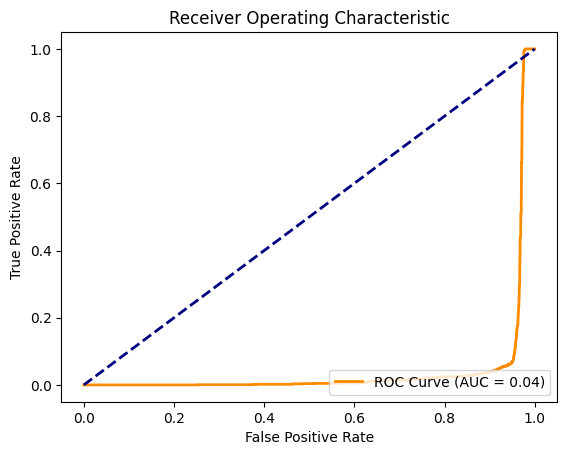

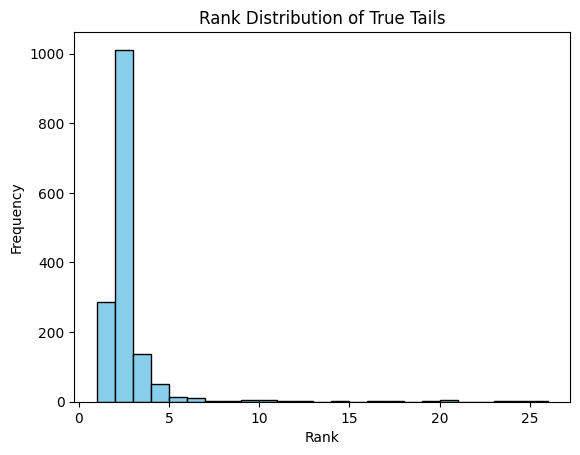

In [43]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import pickle

# Load test data
test_data=pd.read_csv('test.csv')

data2 = test_data.dropna()

# Load mappings
with open("entity2id.pkl", "rb") as f:
    entity2id = pickle.load(f)
with open("relation2id.pkl", "rb") as f:
    relation2id = pickle.load(f)

# Convert test data to IDs
test_triples = data2.apply(lambda row: (entity2id.get(row['DocNo'], -1),
                                        relation2id.get(row['sentence'], -1),
                                        entity2id.get(row['tag'], -1)), axis=1).tolist()
# Remove invalid triples
valid_test_triples = [t for t in test_triples if -1 not in t]

test_heads = torch.tensor([t[0] for t in valid_test_triples])
test_relations = torch.tensor([t[1] for t in valid_test_triples])
test_tails = torch.tensor([t[2] for t in valid_test_triples])

# Load the trained model
embedding_dim = 100
margin = 1.0
model = RotatE(len(entity2id), len(relation2id), embedding_dim, margin)
model.load_state_dict(torch.load('rotatE_model.pth'))
model.eval()

# Evaluation Metrics
ranks = []
y_true = []
y_scores = []

with torch.no_grad():
    for i in range(len(test_heads)):
        head = test_heads[i].unsqueeze(0)
        relation = test_relations[i].unsqueeze(0)
        true_tail = test_tails[i].item()

        # Score all possible tails
        scores = model(head.expand(len(entity2id)),
                       relation.expand(len(entity2id)),
                       torch.arange(len(entity2id)))

        # Get rank of the true tail
        sorted_scores, sorted_indices = torch.sort(scores, descending=False)
        rank = (sorted_indices == true_tail).nonzero(as_tuple=True)[0].item() + 1
        ranks.append(rank)

        # True/False labels for ROC-AUC
        y_true.extend([1 if idx == true_tail else 0 for idx in range(len(entity2id))])
        y_scores.extend(scores.tolist())

# Mean Rank
mean_rank = sum(ranks) / len(ranks)

# Precision, Recall, F1, Accuracy
precision, recall, f1_score, _ = precision_recall_fscore_support(
    [1 if r == 1 else 0 for r in ranks],  # Binary relevance
    [1] * len(ranks),
    average='binary'
)
accuracy = sum([1 if r == 1 else 0 for r in ranks]) / len(ranks)

# AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Results
print(f"Mean Rank: {mean_rank:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {roc_auc:.2f}")

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Rank Distribution Graph
plt.figure()
plt.hist(ranks, bins=range(1, max(ranks) + 1), color='skyblue', edgecolor='black')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Rank Distribution of True Tails')
plt.show()


# ComplEx

In [19]:
import random
random.seed(42)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Ensure PyTorch is installed in the runtime environment
try:
    import torch
except ModuleNotFoundError:
    raise ModuleNotFoundError("PyTorch is not installed. Please install it using 'pip install torch'.")

# Load the training data
data = train_data.dropna()

# Step 1: Prepare entities and relations
entities = list(set(data['DocNo'].unique()).union(set(data['tag'].unique())))
relations = list(data['sentence'].unique())

# Map entities and relations to indices
entity2id = {entity: idx for idx, entity in enumerate(entities)}
relation2id = {relation: idx for idx, relation in enumerate(relations)}

# Convert data to triples in the form of (head, relation, tail)
triples = data.apply(lambda row: (entity2id[row['DocNo']],
                                  relation2id[row['sentence']],
                                  entity2id[row['tag']]), axis=1).tolist()

# ComplEx Model
class ComplEx(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(ComplEx, self).__init__()
        self.entity_embedding_real = nn.Embedding(num_entities, embedding_dim)
        self.entity_embedding_imag = nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding_real = nn.Embedding(num_relations, embedding_dim)
        self.relation_embedding_imag = nn.Embedding(num_relations, embedding_dim)

        nn.init.xavier_uniform_(self.entity_embedding_real.weight)
        nn.init.xavier_uniform_(self.entity_embedding_imag.weight)
        nn.init.xavier_uniform_(self.relation_embedding_real.weight)
        nn.init.xavier_uniform_(self.relation_embedding_imag.weight)

    def forward(self, heads, relations, tails):
        h_real = self.entity_embedding_real(heads)
        h_imag = self.entity_embedding_imag(heads)
        r_real = self.relation_embedding_real(relations)
        r_imag = self.relation_embedding_imag(relations)
        t_real = self.entity_embedding_real(tails)
        t_imag = self.entity_embedding_imag(tails)

        score = (h_real * t_real + h_imag * t_imag) * r_real + \
                (h_real * t_imag - h_imag * t_real) * r_imag

        return torch.sigmoid(torch.sum(score, dim=1))

# Dataset Class
class TripleDataset(Dataset):
    def __init__(self, triples, num_entities):
        self.triples = triples
        self.num_entities = num_entities

    def __len__(self):
        return len(self.triples)

    def __getitem__(self, idx):
        head, relation, tail = self.triples[idx]
        # Generate a negative sample
        negative_tail = np.random.choice(self.num_entities)
        return torch.tensor(head), torch.tensor(relation), torch.tensor(tail), torch.tensor(negative_tail)

# Step 2: Initialize dataset and dataloader
embedding_dim = 50
num_epochs = 100
learning_rate = 1e-3
batch_size = 32

num_entities = len(entities)
num_relations = len(relations)

dataset = TripleDataset(triples, num_entities)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize ComplEx model
model = ComplEx(num_entities, num_relations, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

# Training loop
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for heads, relations, tails, negative_tails in dataloader:
            pos_scores = model(heads, relations, tails) > 0.5
            neg_scores = model(heads, relations, negative_tails) < 0.5
            correct += pos_scores.sum().item() + neg_scores.sum().item()
            total += len(heads) * 2
    return correct / total

for epoch in range(num_epochs):
    total_loss = 0
    model.train()

    for heads, relations, tails, negative_tails in dataloader:
        optimizer.zero_grad()

        # Forward pass for positive and negative samples
        pos_scores = model(heads, relations, tails)
        neg_scores = model(heads, relations, negative_tails)

        # Create targets (1 for positive, 0 for negative)
        targets = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)])
        predictions = torch.cat([pos_scores, neg_scores])

        # Compute loss
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_accuracy = calculate_accuracy(model, dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.2f}, Accuracy: {train_accuracy:.2f}")

print("Training complete.")


Epoch 1/100, Loss: 148.77, Accuracy: 0.84
Epoch 2/100, Loss: 115.87, Accuracy: 0.91
Epoch 3/100, Loss: 80.53, Accuracy: 0.93
Epoch 4/100, Loss: 61.57, Accuracy: 0.95
Epoch 5/100, Loss: 48.34, Accuracy: 0.95
Epoch 6/100, Loss: 39.74, Accuracy: 0.96
Epoch 7/100, Loss: 36.08, Accuracy: 0.96
Epoch 8/100, Loss: 33.34, Accuracy: 0.97
Epoch 9/100, Loss: 30.25, Accuracy: 0.97
Epoch 10/100, Loss: 28.63, Accuracy: 0.97
Epoch 11/100, Loss: 27.54, Accuracy: 0.97
Epoch 12/100, Loss: 26.83, Accuracy: 0.97
Epoch 13/100, Loss: 25.93, Accuracy: 0.97
Epoch 14/100, Loss: 24.63, Accuracy: 0.97
Epoch 15/100, Loss: 24.79, Accuracy: 0.97
Epoch 16/100, Loss: 23.32, Accuracy: 0.97
Epoch 17/100, Loss: 23.49, Accuracy: 0.97
Epoch 18/100, Loss: 24.30, Accuracy: 0.97
Epoch 19/100, Loss: 23.88, Accuracy: 0.97
Epoch 20/100, Loss: 21.97, Accuracy: 0.97
Epoch 21/100, Loss: 22.45, Accuracy: 0.97
Epoch 22/100, Loss: 23.43, Accuracy: 0.97
Epoch 23/100, Loss: 23.46, Accuracy: 0.97
Epoch 24/100, Loss: 23.71, Accuracy: 0.97

Mean Rank: 1.41
Precision: 0.99
Recall: 0.93
F1 Score: 0.96
Accuracy: 0.96
AUC: 0.99


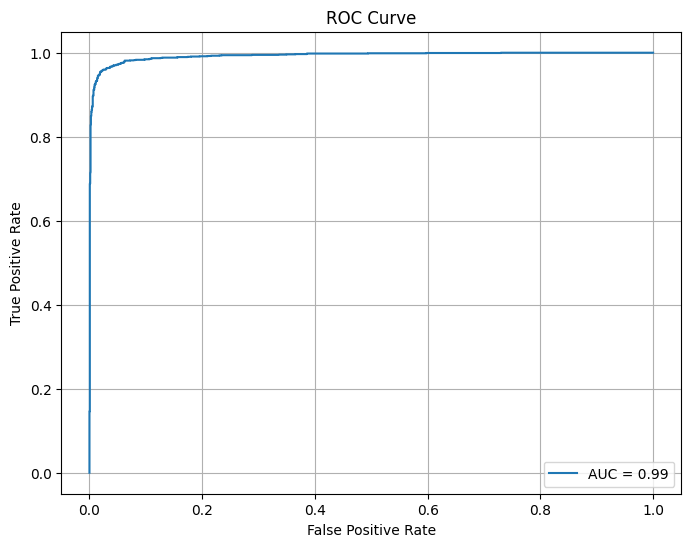

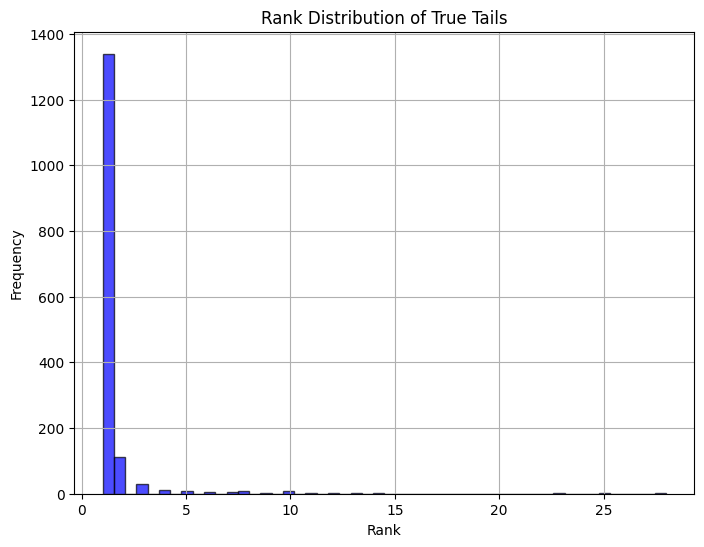

In [21]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt

# Load the test data
test_data = pd.read_csv('test.csv').dropna()

# Map test dataset to triples using the training mappings
test_triples = test_data.apply(
    lambda row: (
        entity2id.get(row['DocNo'], -1),
        relation2id.get(row['sentence'], -1),
        entity2id.get(row['tag'], -1)
    ),
    axis=1
).tolist()

# Filter out triples with unknown entities/relations
test_triples = [triple for triple in test_triples if -1 not in triple]

# Define a function to compute ranks for test triples
def compute_ranks(model, triples, num_entities):
    ranks = []
    with torch.no_grad():
        for head, relation, tail in triples:
            head_tensor = torch.tensor([head] * num_entities)
            relation_tensor = torch.tensor([relation] * num_entities)
            tail_tensor = torch.arange(num_entities)

            # Compute scores for all entities as potential tails
            scores = model(head_tensor, relation_tensor, tail_tensor)
            true_tail_score = scores[tail].item()

            # Compute the rank of the true tail
            rank = torch.sum(scores >= true_tail_score).item()
            ranks.append(rank)
    return ranks

# Reload the trained model
model.eval()

# Compute ranks for the test triples
ranks = compute_ranks(model, test_triples, num_entities)
mean_rank = sum(ranks) / len(ranks)

# Evaluate metrics
true_labels = []
predicted_scores = []

with torch.no_grad():
    for head, relation, tail in test_triples:
        # Score for the true triple
        score = model(torch.tensor([head]), torch.tensor([relation]), torch.tensor([tail]))
        true_labels.append(1)
        predicted_scores.append(score.item())

        # Score for a corrupted triple
        corrupt_tail = np.random.choice(num_entities)
        while corrupt_tail == tail:
            corrupt_tail = np.random.choice(num_entities)

        score_corrupt = model(torch.tensor([head]), torch.tensor([relation]), torch.tensor([corrupt_tail]))
        true_labels.append(0)
        predicted_scores.append(score_corrupt.item())

# Convert scores to binary predictions
predicted_labels = [1 if score > 0.5 else 0 for score in predicted_scores]

# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average="binary")
accuracy = accuracy_score(true_labels, predicted_labels)
auc = roc_auc_score(true_labels, predicted_scores)

# Print Metrics
metrics = {
    "Mean Rank": mean_rank,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Accuracy": accuracy,
    "AUC": auc,
}

for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Generate ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Rank Distribution Plot
plt.figure(figsize=(8, 6))
plt.hist(ranks, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Rank Distribution of True Tails")
plt.grid()
plt.show()


# RESCAL

In [30]:
import random
random.seed(42)

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, roc_curve

# Load the training data
train_data = pd.read_csv('train.csv').dropna()

data = train_data.dropna()

# Step 1: Prepare entities and relations
entities = list(set(data['DocNo'].unique()).union(set(data['tag'].unique())))
relations = list(data['sentence'].unique())

# Map entities and relations to indices
entity2id = {entity: idx for idx, entity in enumerate(entities)}
relation2id = {relation: idx for idx, relation in enumerate(relations)}

# Convert data to triples in the form of (head, relation, tail)
triples = data.apply(lambda row: (entity2id[row['DocNo']],
                                  relation2id[row['sentence']],
                                  entity2id[row['tag']]), axis=1).tolist()

# RESCAL Model
class RESCAL(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(RESCAL, self).__init__()
        self.entity_embedding = nn.Embedding(num_entities, embedding_dim)
        self.relation_matrices = nn.Parameter(torch.randn(num_relations, embedding_dim, embedding_dim))
        nn.init.xavier_uniform_(self.entity_embedding.weight)
        nn.init.xavier_uniform_(self.relation_matrices)

    def forward(self, heads, relations, tails):
        h = self.entity_embedding(heads)
        t = self.entity_embedding(tails)
        r = self.relation_matrices[relations]

        # RESCAL scoring function
        scores = torch.sum(h @ r * t, dim=1)
        return torch.sigmoid(scores)

# Dataset Class
class TripleDataset(Dataset):
    def __init__(self, triples, num_entities):
        self.triples = triples
        self.num_entities = num_entities

    def __len__(self):
        return len(self.triples)

    def __getitem__(self, idx):
        head, relation, tail = self.triples[idx]
        # Generate a negative sample
        negative_tail = np.random.choice(self.num_entities)
        return torch.tensor(head), torch.tensor(relation), torch.tensor(tail), torch.tensor(negative_tail)

# Step 2: Initialize dataset and dataloader
embedding_dim = 100
num_epochs = 100
learning_rate = 1e-3
batch_size = 32

num_entities = len(entities)
num_relations = len(relations)

dataset = TripleDataset(triples, num_entities)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize RESCAL model
model = RESCAL(num_entities, num_relations, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

# Training loop
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for heads, relations, tails, negative_tails in dataloader:
            pos_scores = model(heads, relations, tails) > 0.5
            neg_scores = model(heads, relations, negative_tails) < 0.5
            correct += pos_scores.sum().item() + neg_scores.sum().item()
            total += len(heads) * 2
    return correct / total

for epoch in range(num_epochs):
    total_loss = 0
    model.train()

    for heads, relations, tails, negative_tails in dataloader:
        optimizer.zero_grad()

        # Forward pass for positive and negative samples
        pos_scores = model(heads, relations, tails)
        neg_scores = model(heads, relations, negative_tails)

        # Create targets (1 for positive, 0 for negative)
        targets = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)])
        predictions = torch.cat([pos_scores, neg_scores])

        # Compute loss
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_accuracy = calculate_accuracy(model, dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.2f}, Accuracy: {train_accuracy:.2f}")

print("Training complete.")

# Save the model
torch.save(model.state_dict(), 'rescal_model.pth')



Epoch 1/100, Loss: 88.65, Accuracy: 99.61
Epoch 2/100, Loss: 11.65, Accuracy: 99.96
Epoch 3/100, Loss: 1.71, Accuracy: 99.98
Epoch 4/100, Loss: 0.85, Accuracy: 100.00
Epoch 5/100, Loss: 0.45, Accuracy: 100.00
Epoch 6/100, Loss: 0.72, Accuracy: 100.00
Epoch 7/100, Loss: 0.37, Accuracy: 99.98
Epoch 8/100, Loss: 0.35, Accuracy: 100.00
Epoch 9/100, Loss: 0.16, Accuracy: 99.98
Epoch 10/100, Loss: 0.22, Accuracy: 100.00
Epoch 11/100, Loss: 0.07, Accuracy: 100.00
Epoch 12/100, Loss: 0.06, Accuracy: 100.00
Epoch 13/100, Loss: 0.07, Accuracy: 100.00
Epoch 14/100, Loss: 0.09, Accuracy: 99.99
Epoch 15/100, Loss: 0.08, Accuracy: 100.00
Epoch 16/100, Loss: 0.11, Accuracy: 100.00
Epoch 17/100, Loss: 0.06, Accuracy: 100.00
Epoch 18/100, Loss: 0.19, Accuracy: 99.93
Epoch 19/100, Loss: 0.05, Accuracy: 100.00
Epoch 20/100, Loss: 0.03, Accuracy: 100.00
Epoch 21/100, Loss: 0.06, Accuracy: 100.00
Epoch 22/100, Loss: 0.02, Accuracy: 100.00
Epoch 23/100, Loss: 0.09, Accuracy: 100.00
Epoch 24/100, Loss: 0.01,

<ipython-input-31-749abcf0b21b>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(checkpoint_path)


Metrics:
Mean Rank: 59.79
Precision: 0.50
Recall: 0.50
F1 Score: 0.50
AUC: 0.48
Accuracy: 0.91


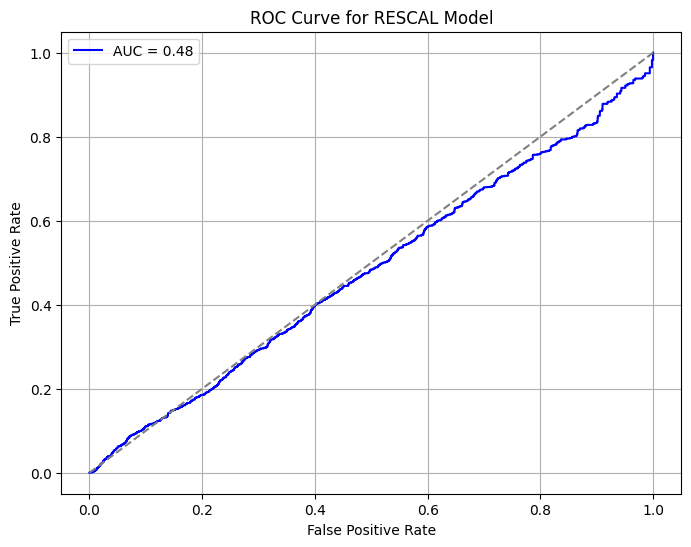

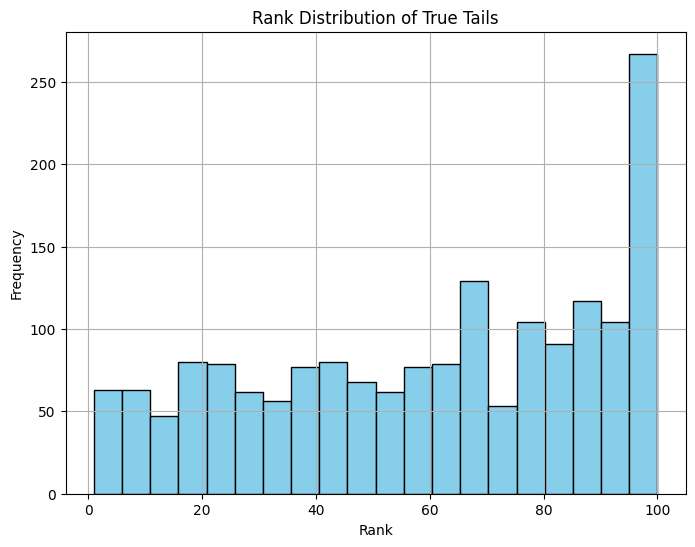

In [31]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Load the test and train data
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path).dropna()
    test_data = pd.read_csv(test_path).dropna()
    return train_data, test_data

# Step 1: Create mappings for entities and relations based on training data
def create_mappings(train_data):
    entities = list(set(train_data['DocNo'].unique()).union(set(train_data['tag'].unique())))
    relations = list(train_data['sentence'].unique())
    entity2id = {entity: idx for idx, entity in enumerate(entities)}
    relation2id = {relation: idx for idx, relation in enumerate(relations)}
    return entity2id, relation2id

# Step 2: Convert data to triples while dynamically updating mappings
def convert_to_triples(data, entity2id, relation2id):
    triples = []
    for _, row in data.iterrows():
        head = entity2id.get(row['DocNo'], len(entity2id))
        relation = relation2id.get(row['sentence'], len(relation2id))
        tail = entity2id.get(row['tag'], len(entity2id))

        # Update mappings dynamically if new entities/relations are found
        entity2id.setdefault(row['DocNo'], head)
        relation2id.setdefault(row['sentence'], relation)
        entity2id.setdefault(row['tag'], tail)

        triples.append((head, relation, tail))
    return triples

# Function to compute predictions and ranks
def predict_tail_ranks_rescal(model, triples, entity_count):
    ranks = []
    y_true = []
    y_scores = []

    with torch.no_grad():
        for head, relation, tail in triples:
            head_tensor = torch.tensor([head])
            relation_tensor = torch.tensor([relation])
            all_tails_tensor = torch.arange(entity_count)

            # Compute scores for all possible tails
            scores = model(head_tensor, relation_tensor, all_tails_tensor).squeeze(0)
            scores = scores.detach().cpu().numpy()

            # Calculate rank
            rank = np.argsort(-scores).tolist().index(tail) + 1
            ranks.append(rank)

            # Collect scores for ROC/AUC
            y_true.append(1)
            y_scores.append(scores[tail])

            for neg_tail in range(entity_count):
                if neg_tail != tail:
                    y_true.append(0)
                    y_scores.append(scores[neg_tail])

    return ranks, y_true, y_scores

# Load trained RESCAL model with dynamic resizing
def load_rescal_model(checkpoint_path, num_entities, num_relations, embedding_dim):
    saved_state = torch.load(checkpoint_path)

    pretrained_num_entities = saved_state['entity_embedding.weight'].size(0)
    pretrained_num_relations = saved_state['relation_matrices'].size(0)

    model = RESCAL(num_entities, num_relations, embedding_dim)

    if num_entities != pretrained_num_entities:
        new_entity_weights = torch.cat([
            saved_state['entity_embedding.weight'],
            torch.empty(num_entities - pretrained_num_entities, embedding_dim).uniform_(-0.01, 0.01)
        ], dim=0) if num_entities > pretrained_num_entities else saved_state['entity_embedding.weight'][:num_entities]
        saved_state['entity_embedding.weight'] = new_entity_weights

    if num_relations != pretrained_num_relations:
        new_relation_weights = torch.cat([
            saved_state['relation_matrices'],
            torch.empty(num_relations - pretrained_num_relations, embedding_dim, embedding_dim).uniform_(-0.01, 0.01)
        ], dim=0) if num_relations > pretrained_num_relations else saved_state['relation_matrices'][:num_relations]
        saved_state['relation_matrices'] = new_relation_weights

    model.load_state_dict(saved_state)
    return model

# Evaluate and plot metrics
def evaluate_and_plot_metrics(ranks, y_true, y_scores):
    y_pred = [1 if score >= 0.5 else 0 for score in y_scores]

    mean_rank = np.mean(ranks)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc = roc_auc_score(y_true, y_scores)
    accuracy = accuracy_score(y_true, y_pred)

    print("Metrics:")
    print(f"Mean Rank: {mean_rank:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='b')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for RESCAL Model')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Rank Distribution
    plt.figure(figsize=(8, 6))
    plt.hist(ranks, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title('Rank Distribution of True Tails')
    plt.grid()
    plt.show()

# Main execution
if __name__ == "__main__":
    train_data, test_data = load_data('train.csv', 'test.csv')

    # Create mappings and convert data to triples
    entity2id, relation2id = create_mappings(train_data)
    test_triples = convert_to_triples(test_data, entity2id, relation2id)

    # Load model dynamically
    model = load_rescal_model('rescal_model.pth', len(entity2id), len(relation2id), 100)
    model.eval()

    # Predict and evaluate
    ranks, y_true, y_scores = predict_tail_ranks_rescal(model, test_triples, len(entity2id))
    evaluate_and_plot_metrics(ranks, y_true, y_scores)
